# Load Libraries

In [1]:
reload_data = False

In [2]:
# imports for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# imports for vision tasks
import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import pydicom

# imports for preparing dataset
import os
import shutil
import zipfile
import pandas as pd
from skimage import io
from PIL import Image
import numpy as np
import timm

# imports for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm

In [3]:
def load_processed_dataset(base_load_path, verbose=False):
    """
    Load the processed dataset from disk.
    
    Args:
        base_load_path (str): Path where the dataset is saved
    
    Returns:
        dict: Loaded condition data
        dict: Configuration data
    """
    base_path = Path(base_load_path)
    
    if not base_path.exists():
        raise ValueError(f"Dataset path {base_path} does not exist")
    
    # Load configuration
    with open(base_path / 'config.json', 'r') as f:
        config = json.load(f)
    
    # Initialize condition data dictionary
    loaded_condition_data = {}
    
    # Load data for each condition
    for condition in config['core_conditions']:
        condition_path = base_path / condition
        
        if condition_path.exists():
            loaded_condition_data[condition] = {
                'images': torch.load(condition_path / 'images.pt', weights_only=False),
                'labels': torch.load(condition_path / 'labels.pt', weights_only=False),
                'metadata': pd.read_pickle(condition_path / 'metadata.pkl')
            }
    
    if verbose is True :
        print("\nDataset successfully loaded")
        print("\nDataset Summary:")
        for condition, data in loaded_condition_data.items():
            print(f"\n{condition}:")
            print(f"Total samples: {len(data['images'])}")
            label_dist = torch.bincount(data['labels'])
            for severity, idx in config['severity_mapping'].items():
                if idx < len(label_dist):
                    print(f"  {severity}: {label_dist[idx].item()}")
    
    return loaded_condition_data, config


# Data Preparation

## Set Class Mapping

In [4]:
class_mapping_1 = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}

img_sizes_coords = pd.DataFrame(columns=['image_size', 'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
 'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1',
 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1',
 'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1',
 'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1'])

## Read and Transform all Images Dataset

In [5]:
import os
import pandas as pd
import numpy as np
import pydicom
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
from collections import defaultdict

# Define core conditions
CORE_CONDITIONS = [
    'spinal_canal_stenosis',
    'left_neural_foraminal_narrowing',
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

# Define label mapping
SEVERITY_MAPPING = {
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
}

# Create dictionaries to store data for each condition
condition_data = {
    condition: {
        'images': [],
        'labels': [],
        'metadata': []  # To store additional info like patient_id, coordinates, etc.
    }
    for condition in CORE_CONDITIONS
}

base_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification"
train_labels = pd.read_csv(os.path.join(base_dir, 'train.csv'))
train_coords = pd.read_csv(os.path.join(base_dir, 'train_label_coordinates.csv'))

train_dir = os.path.join(base_dir, 'train_images')

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_dicom_image(file_path):
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array
    if img.ndim == 2:
        img = img.astype(np.uint8)
        pil_image = Image.fromarray(img, mode='L')
    else:
        pil_image = Image.fromarray(img).convert('gray')
    return pil_image

def get_condition_columns(condition, train_labels):
    """Get all columns related to a specific condition"""
    return [col for col in train_labels.columns if condition.replace('_', ' ') in col.lower()]

print("Starting image processing...")

if os.path.exists("/kaggle/working/processed_spine_dataset") and reload_data is False:
    # Load preprocessed data if it exists
    loaded_data, config = load_processed_dataset('/kaggle/working/processed_spine_dataset')
    
    condition_data = loaded_data
else:
    # Process images for each patient
    for pat_id in tqdm(os.listdir(train_dir), desc="Processing patients"):
        for ser_id in os.listdir(os.path.join(train_dir, pat_id)):
            for img_id in os.listdir(os.path.join(train_dir, pat_id, ser_id)):
                coords = train_coords[
                    (train_coords['study_id'] == int(pat_id)) &
                    (train_coords['series_id'] == int(ser_id)) &
                    (train_coords['instance_number'] == int(img_id[:-4]))
                ]

                img_path = os.path.join(train_dir, pat_id, ser_id, img_id)

                if coords.empty:
                    continue

                if not os.path.exists(img_path):
                    print('Image not found: ', img_path)
                    continue

                image = load_dicom_image(img_path)

                # Process each coordinate
                for index, row in coords.iterrows():
                    condition = row['condition'].replace(' ', '_').lower()
                    
                    # Skip if not a core condition
                    if condition not in CORE_CONDITIONS:
                        continue

                    level = row['level'].replace('/', '_').lower()
                    col = f"{condition}_{level}"
                    
                    # Get severity from train_labels
                    severity = train_labels[
                        train_labels['study_id'] == int(pat_id)
                    ][col].values[0]

                    if pd.isna(severity):
                        continue

                    # Convert severity to numerical label using mapping
                    if severity not in SEVERITY_MAPPING:
                        print(f"Unknown severity value: {severity}")
                        continue
                        
                    numerical_label = SEVERITY_MAPPING[severity]

                    # Process the image
                    cpy_image = image.copy()
                    width, height = cpy_image.size
                    x, y = row['x'], row['y']

                    # Crop the region of interest
                    window_size = int(0.1 * min(cpy_image.size))
                    start_x = max(0, int(x - window_size / 2))
                    end_x = min(cpy_image.size[0], int(x + window_size / 2))
                    start_y = max(0, int(y - window_size / 2))
                    end_y = min(cpy_image.size[1], int(y + window_size / 2))
                    
                    cropped_image = cpy_image.crop((start_x, start_y, end_x, end_y))
                    transformed_image = transform(cropped_image)

                    # Store the data
                    condition_data[condition]['images'].append(transformed_image)
                    condition_data[condition]['labels'].append(torch.tensor(numerical_label))
                    condition_data[condition]['metadata'].append({
                        'patient_id': pat_id,
                        'series_id': ser_id,
                        'image_id': img_id,
                        'level': level,
                        'coordinates': (x, y),
                        'original_size': (width, height),
                        'severity_text': severity  # Store original text label
                    })

    # Convert lists to tensors
    for condition in CORE_CONDITIONS:
        if condition_data[condition]['images']:
            condition_data[condition]['images'] = torch.stack(condition_data[condition]['images'])
            condition_data[condition]['labels'] = torch.stack(condition_data[condition]['labels'])
            condition_data[condition]['metadata'] = pd.DataFrame(condition_data[condition]['metadata'])

# Print summary statistics
print("\nDataset Summary:")
for condition in CORE_CONDITIONS:
    num_samples = len(condition_data[condition]['images'])
    if num_samples > 0:
        label_dist = torch.bincount(torch.stack(condition_data[condition]['labels']) 
                                  if isinstance(condition_data[condition]['labels'], list) 
                                  else condition_data[condition]['labels'])
        print(f"\n{condition}:")
        print(f"Total samples: {num_samples}")
        print("Label distribution:")
        for severity, count in zip(SEVERITY_MAPPING.keys(), label_dist.tolist()):
            print(f"  {severity}: {count}")

Starting image processing...


Processing patients: 100%|██████████| 1975/1975 [11:54<00:00,  2.76it/s]



Dataset Summary:

spinal_canal_stenosis:
Total samples: 9753
Label distribution:
  Normal/Mild: 8552
  Moderate: 732
  Severe: 469

left_neural_foraminal_narrowing:
Total samples: 9860
Label distribution:
  Normal/Mild: 7671
  Moderate: 1792
  Severe: 397

right_neural_foraminal_narrowing:
Total samples: 9829
Label distribution:
  Normal/Mild: 7684
  Moderate: 1767
  Severe: 378

left_subarticular_stenosis:
Total samples: 9603
Label distribution:
  Normal/Mild: 6857
  Moderate: 1834
  Severe: 912

right_subarticular_stenosis:
Total samples: 9612
Label distribution:
  Normal/Mild: 6862
  Moderate: 1825
  Severe: 925


# EDA

## Print Sample Images

/tmp/ipykernel_17/979733844.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Creating visualization report for the dataset...

1. Overall Dataset Summary


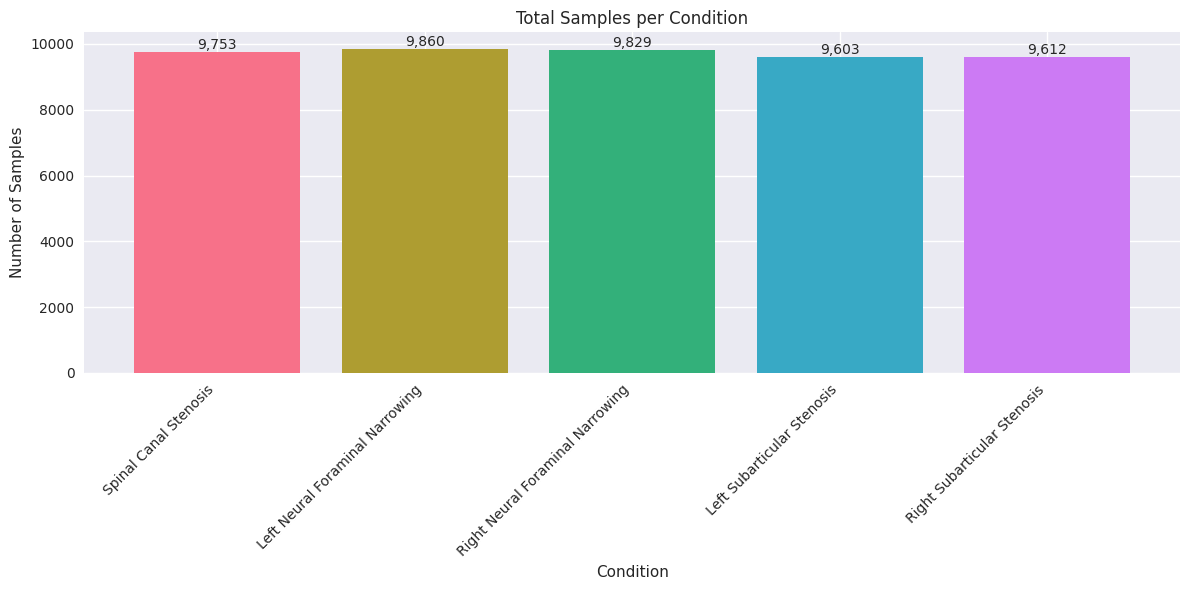


2. Class Distribution Across Conditions


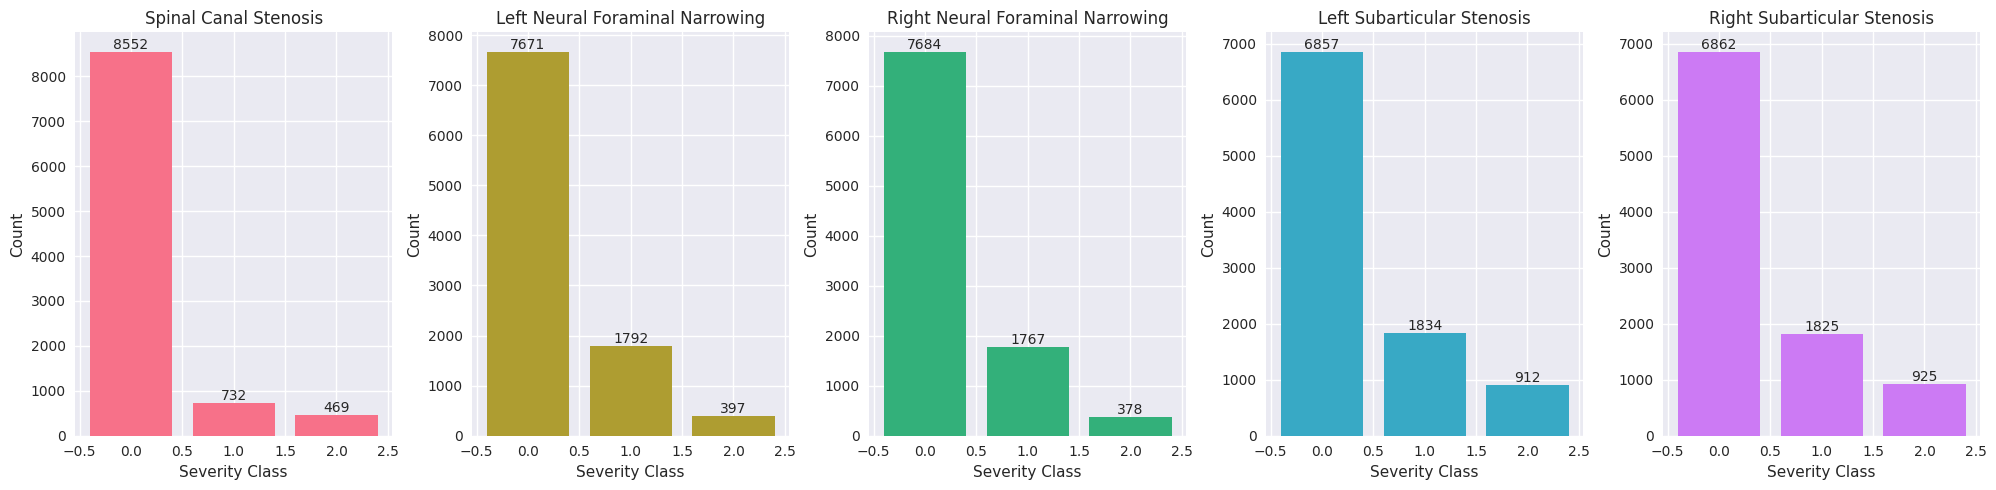


3. Spinal Level Distribution Across Conditions


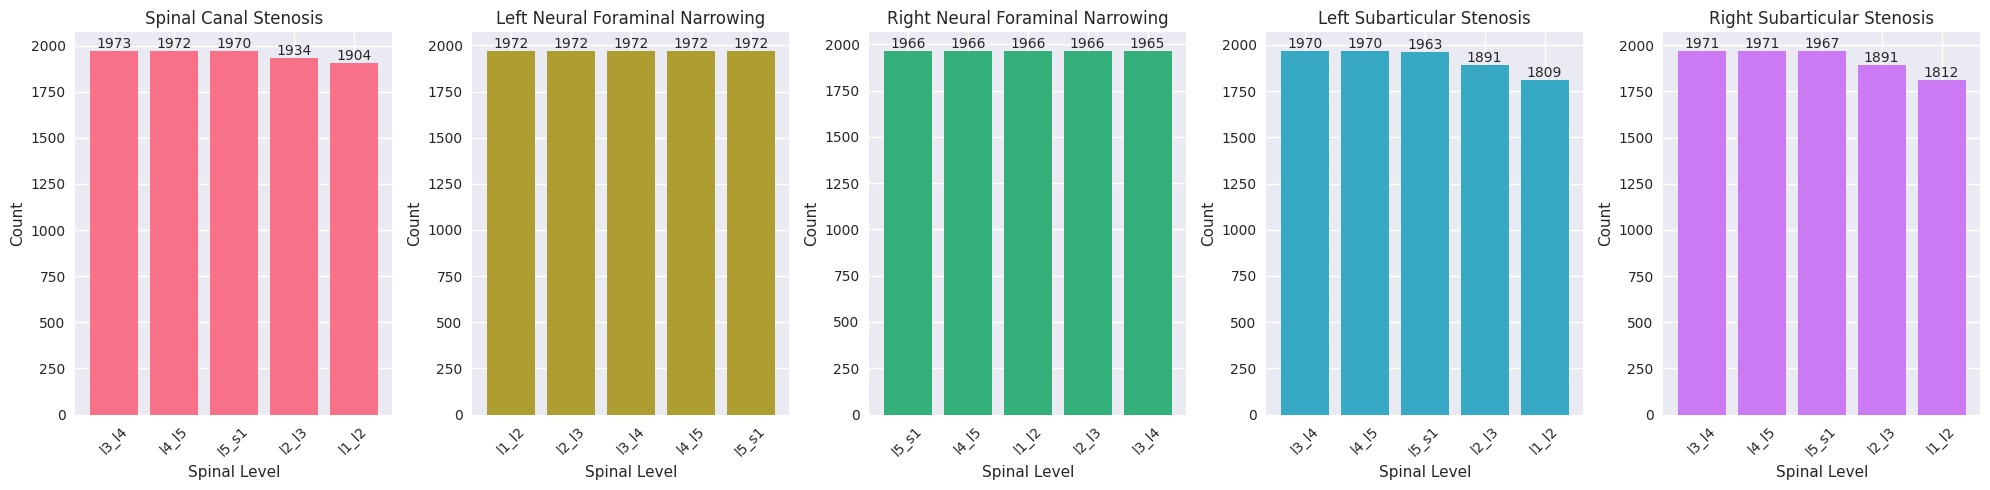


4. Sample Images for Each Condition

Sample images for Spinal Canal Stenosis:


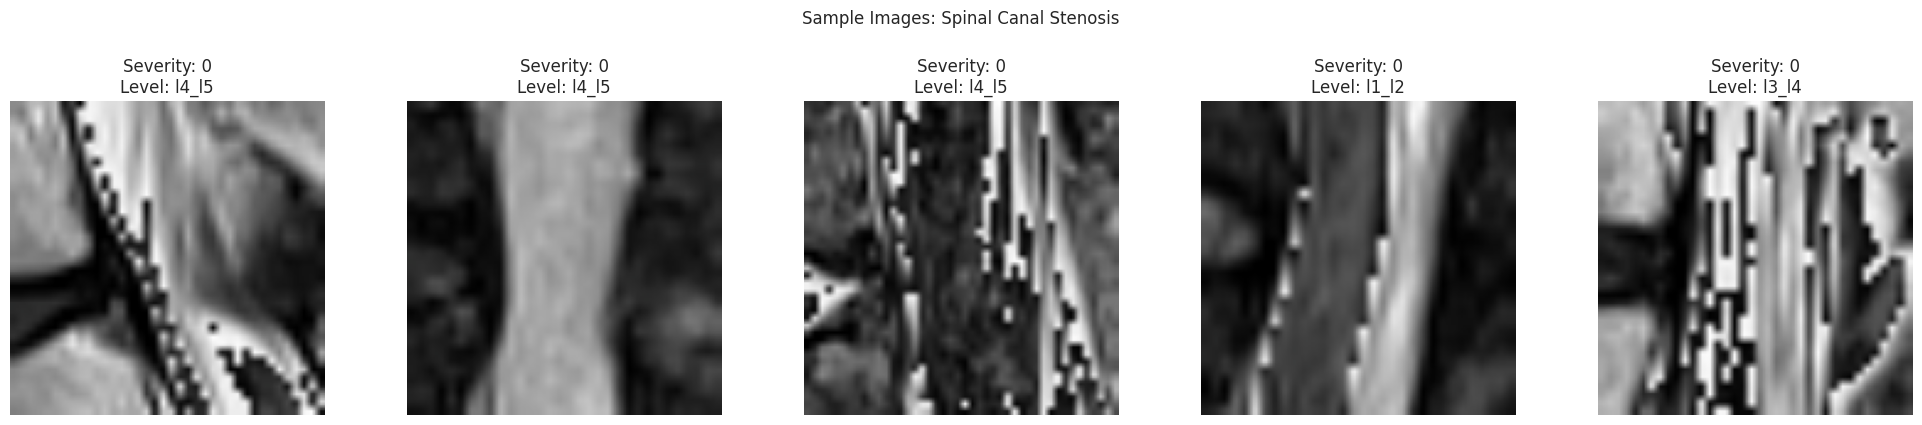


Sample images for Left Neural Foraminal Narrowing:


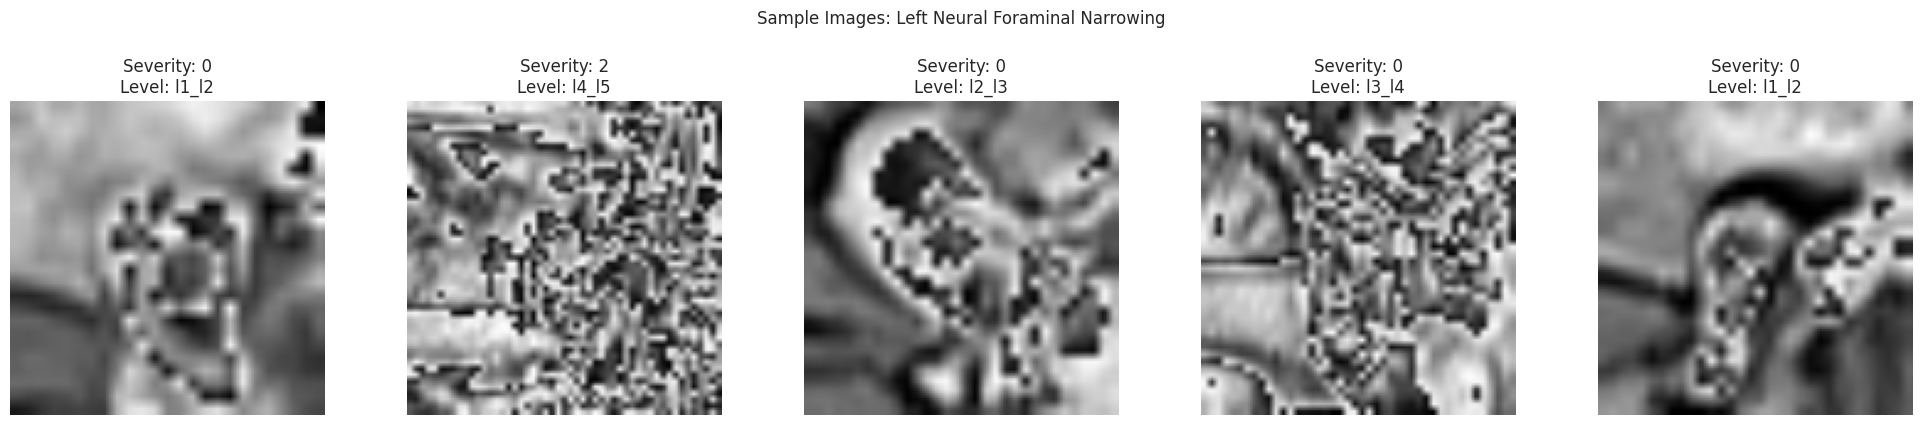


Sample images for Right Neural Foraminal Narrowing:


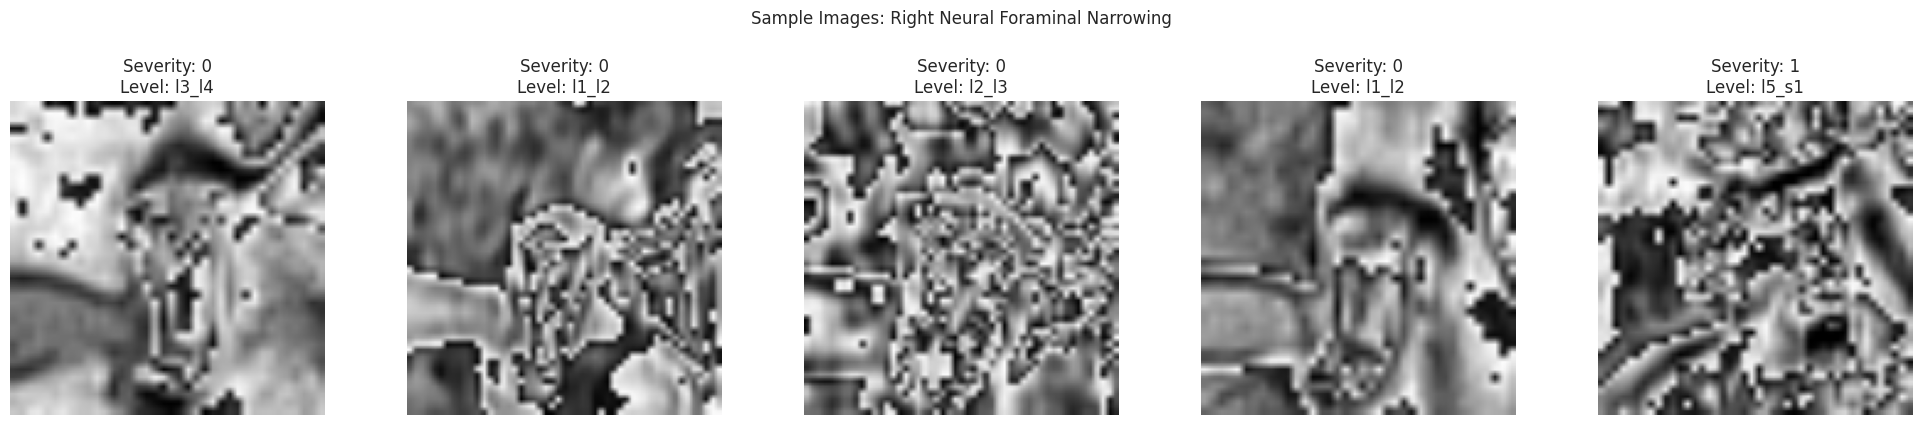


Sample images for Left Subarticular Stenosis:


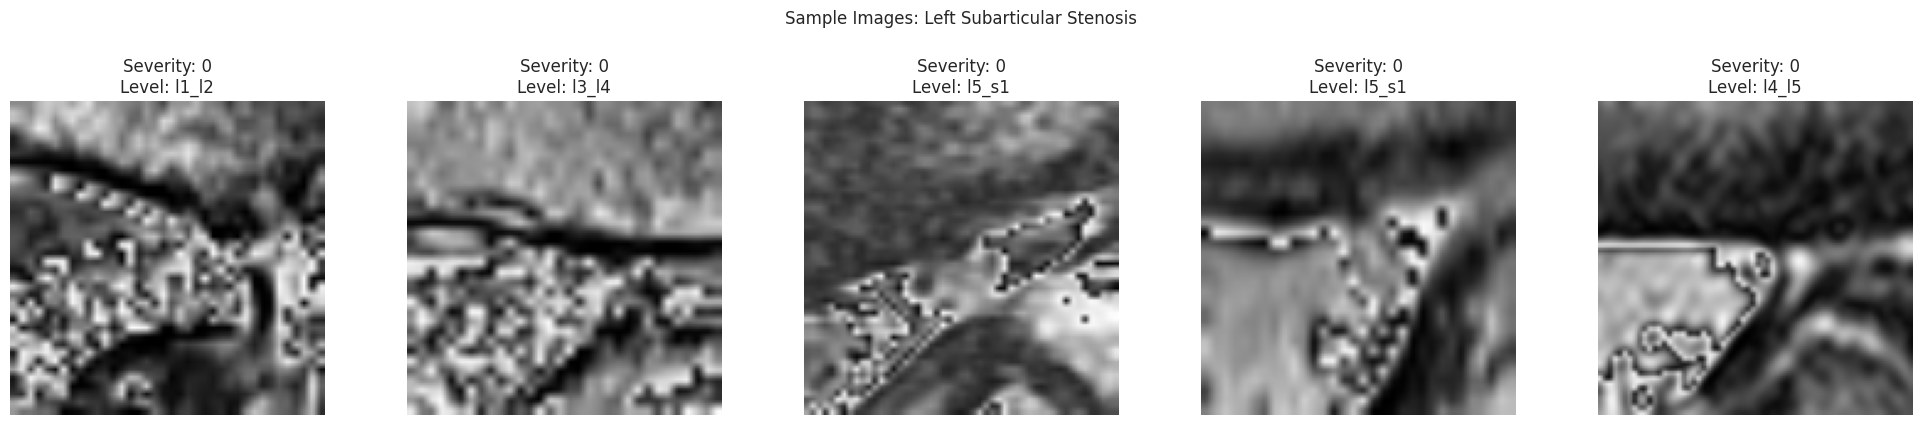


Sample images for Right Subarticular Stenosis:


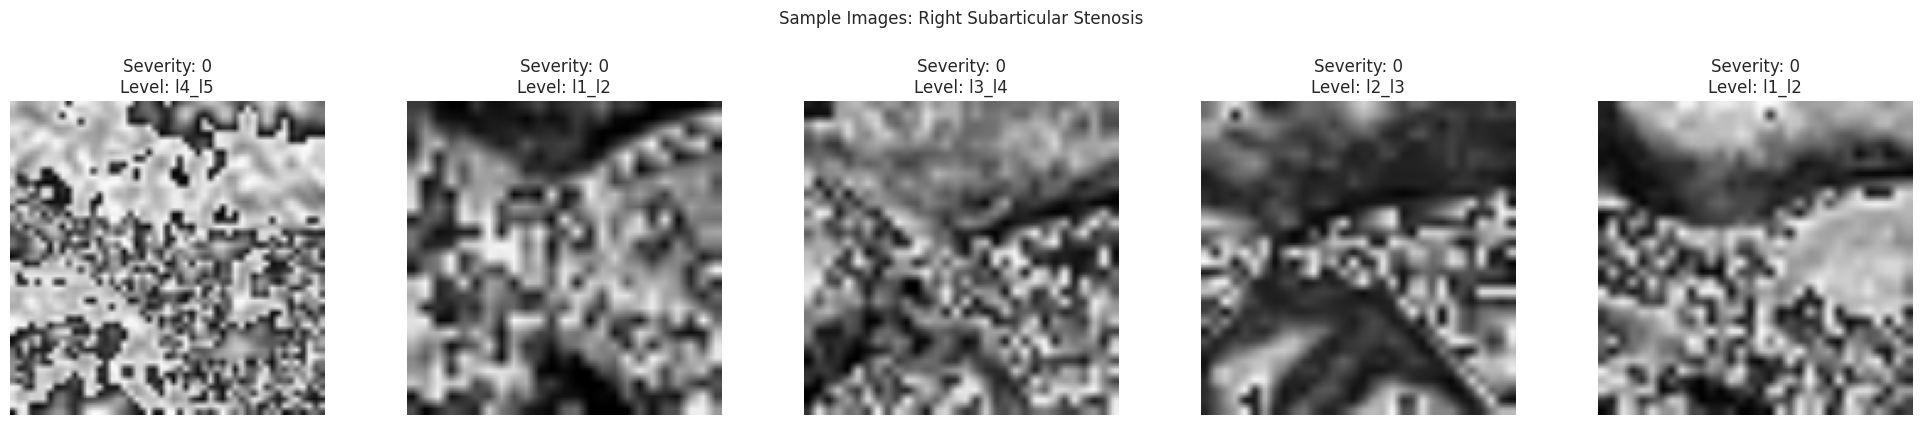


5. Severity Distribution by Spinal Level

Severity distribution for Spinal Canal Stenosis:


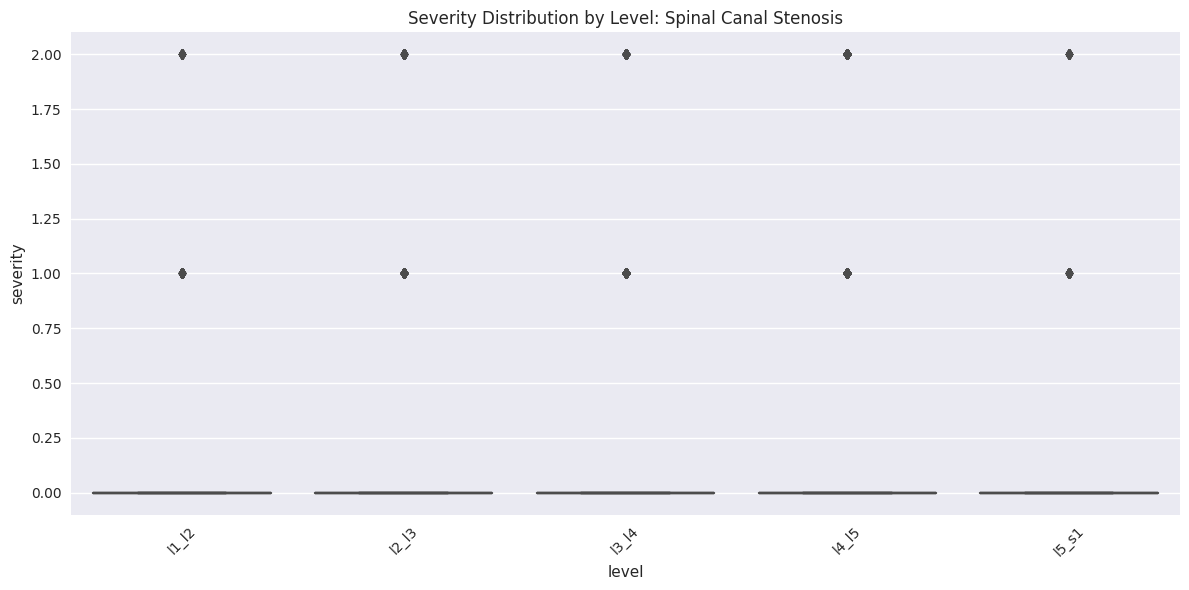


Severity distribution for Left Neural Foraminal Narrowing:


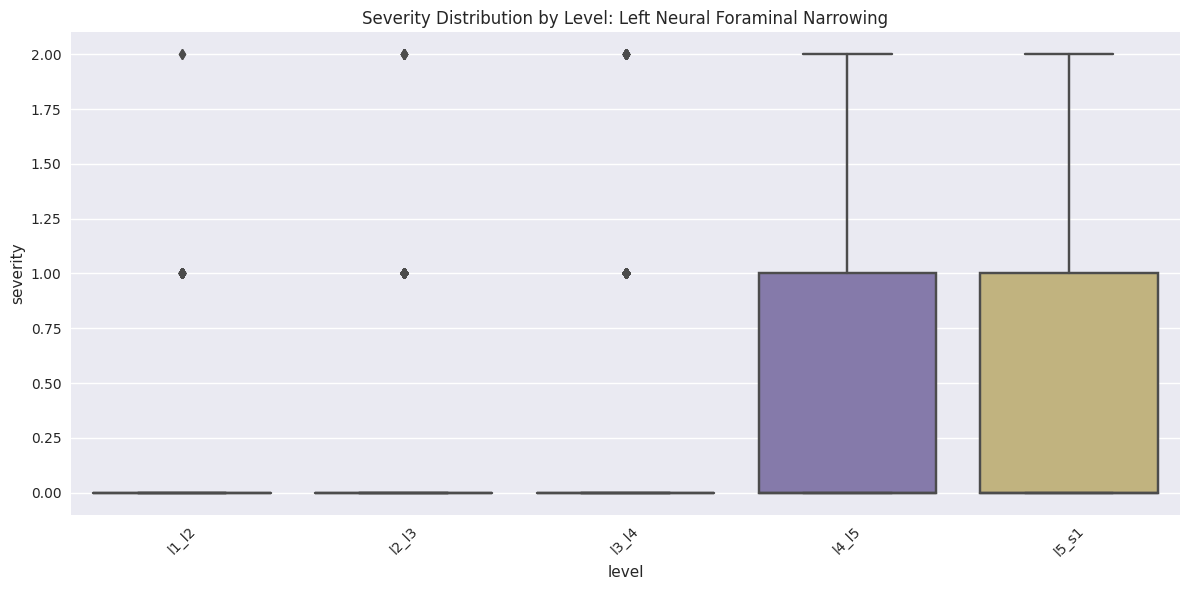


Severity distribution for Right Neural Foraminal Narrowing:


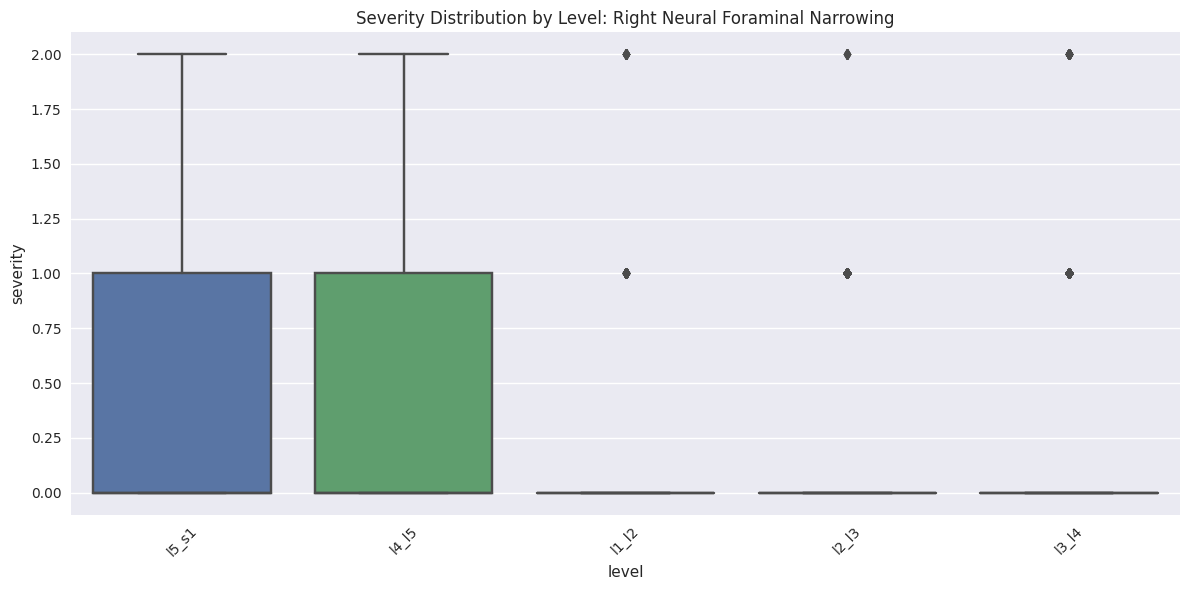


Severity distribution for Left Subarticular Stenosis:


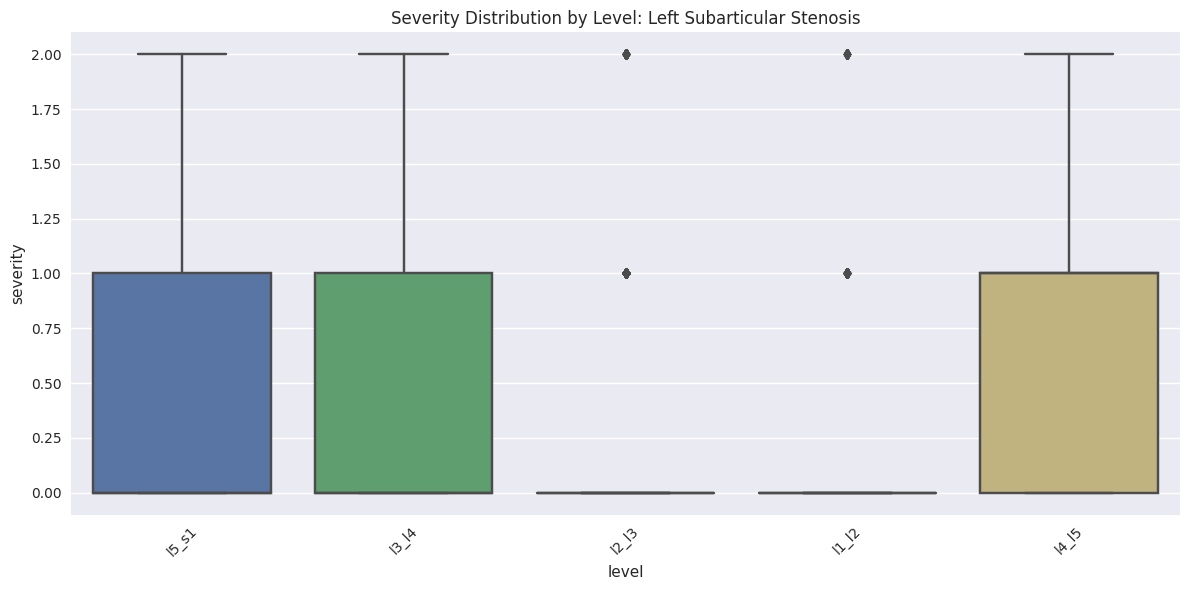


Severity distribution for Right Subarticular Stenosis:


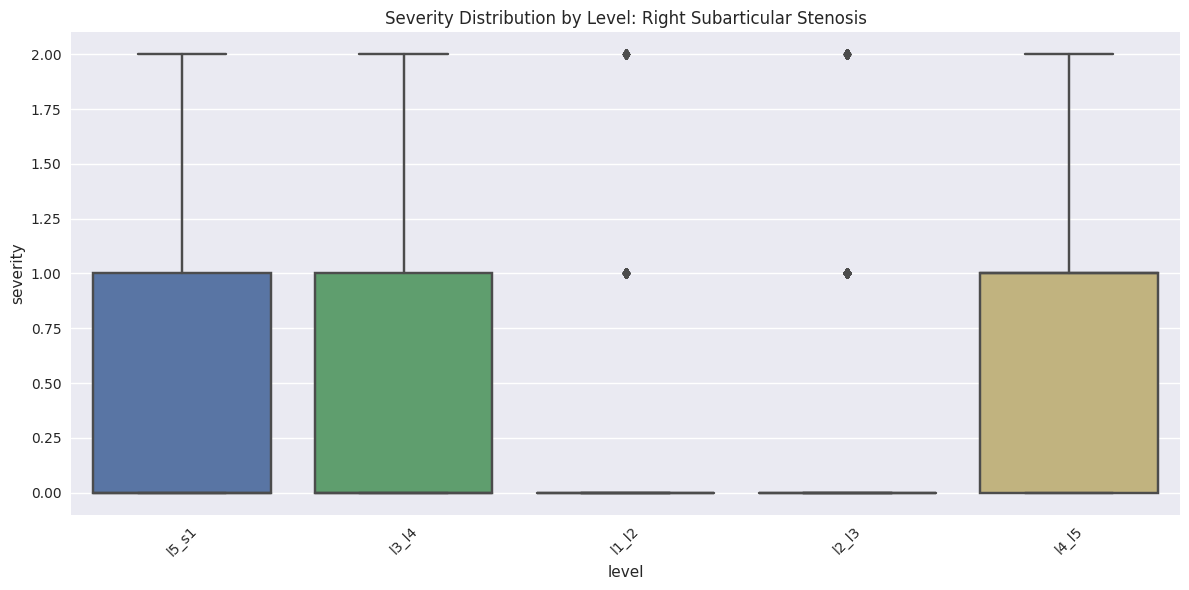

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from typing import Dict, Any
import math

class DatasetVisualizer:
    def __init__(self, condition_data: Dict[str, Dict[str, Any]]):
        self.condition_data = condition_data
        self.conditions = list(condition_data.keys())
        
        # Set style
        plt.style.use('seaborn')
        self.colors = sns.color_palette("husl", len(self.conditions))
    
    def denormalize_image(self, img: torch.Tensor) -> np.ndarray:
        """Denormalize the image for visualization"""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.numpy().transpose(1, 2, 0)
        return np.clip(img, 0, 1)
    
    def plot_sample_images(self, condition: str, num_samples: int = 5):
        """Plot sample images for a specific condition"""
        images = self.condition_data[condition]['images']
        labels = self.condition_data[condition]['labels']
        metadata = self.condition_data[condition]['metadata']
        
        if len(images) == 0:
            print(f"No images available for {condition}")
            return
        
        # Randomly select indices
        indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
        
        # Create subplot grid
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 4, 4))
        if num_samples == 1:
            axes = [axes]
        
        fig.suptitle(f'Sample Images: {condition.replace("_", " ").title()}', y=1.05)
        
        for idx, ax in enumerate(axes):
            if idx < len(indices):
                img = images[indices[idx]]
                label = labels[indices[idx]].item()
                meta = metadata.iloc[indices[idx]]
                
                # Display image
                img_display = self.denormalize_image(img)
                ax.imshow(img_display, cmap='gray')
                ax.set_title(f'Severity: {label}\nLevel: {meta["level"]}')
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def plot_class_distribution(self):
        """Plot class distribution for all conditions"""
        fig, axes = plt.subplots(1, len(self.conditions), figsize=(20, 5))
        if len(self.conditions) == 1:
            axes = [axes]
        
        for idx, (condition, ax) in enumerate(zip(self.conditions, axes)):
            if len(self.condition_data[condition]['labels']) > 0:
                labels = self.condition_data[condition]['labels']
                if isinstance(labels, list):
                    labels = torch.stack(labels)
                
                # Calculate class distribution
                label_counts = torch.bincount(labels)
                
                # Create bar plot
                ax.bar(range(len(label_counts)), label_counts, color=self.colors[idx])
                ax.set_title(condition.replace('_', ' ').title())
                ax.set_xlabel('Severity Class')
                ax.set_ylabel('Count')
                
                # Add value labels on top of bars
                for i, count in enumerate(label_counts):
                    ax.text(i, count.item(), str(count.item()), 
                           ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def plot_level_distribution(self):
        """Plot distribution of spinal levels for each condition"""
        fig, axes = plt.subplots(1, len(self.conditions), figsize=(20, 5))
        if len(self.conditions) == 1:
            axes = [axes]
        
        for idx, (condition, ax) in enumerate(zip(self.conditions, axes)):
            if len(self.condition_data[condition]['metadata']) > 0:
                level_counts = self.condition_data[condition]['metadata']['level'].value_counts()
                
                # Create bar plot
                ax.bar(range(len(level_counts)), level_counts, color=self.colors[idx])
                ax.set_title(condition.replace('_', ' ').title())
                ax.set_xlabel('Spinal Level')
                ax.set_ylabel('Count')
                
                # Set x-tick labels
                ax.set_xticks(range(len(level_counts)))
                ax.set_xticklabels(level_counts.index, rotation=45)
                
                # Add value labels
                for i, count in enumerate(level_counts):
                    ax.text(i, count, str(count), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def plot_severity_by_level(self, condition: str):
        """Plot severity distribution across different spinal levels for a specific condition"""
        if len(self.condition_data[condition]['metadata']) == 0:
            print(f"No data available for {condition}")
            return
        
        data = pd.DataFrame({
            'level': self.condition_data[condition]['metadata']['level'],
            'severity': self.condition_data[condition]['labels'].numpy()
        })
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=data, x='level', y='severity')
        plt.title(f'Severity Distribution by Level: {condition.replace("_", " ").title()}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_dataset_summary(self):
        """Plot overall summary of the dataset"""
        # Calculate total samples per condition
        sample_counts = {condition: len(data['images']) 
                        for condition, data in self.condition_data.items()}
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(range(len(sample_counts)), list(sample_counts.values()),
                      color=self.colors)
        plt.title('Total Samples per Condition')
        plt.xlabel('Condition')
        plt.ylabel('Number of Samples')
        plt.xticks(range(len(sample_counts)), 
                  [cond.replace('_', ' ').title() for cond in sample_counts.keys()],
                  rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

# Example usage
visualizer = DatasetVisualizer(condition_data)

# Create a comprehensive visualization report
def create_visualization_report():
    print("Creating visualization report for the dataset...\n")
    
    # 1. Overall dataset summary
    print("1. Overall Dataset Summary")
    visualizer.plot_dataset_summary()
    
    # 2. Class distribution for all conditions
    print("\n2. Class Distribution Across Conditions")
    visualizer.plot_class_distribution()
    
    # 3. Level distribution for all conditions
    print("\n3. Spinal Level Distribution Across Conditions")
    visualizer.plot_level_distribution()
    
    # 4. Sample images for each condition
    print("\n4. Sample Images for Each Condition")
    for condition in visualizer.conditions:
        print(f"\nSample images for {condition.replace('_', ' ').title()}:")
        visualizer.plot_sample_images(condition)
    
    # 5. Severity distribution by level for each condition
    print("\n5. Severity Distribution by Spinal Level")
    for condition in visualizer.conditions:
        print(f"\nSeverity distribution for {condition.replace('_', ' ').title()}:")
        visualizer.plot_severity_by_level(condition)

# Run the visualization report
create_visualization_report()

# Save Dataset

In [7]:
import os
import torch
import pandas as pd
import json
from pathlib import Path
import shutil

def save_processed_dataset(condition_data, base_save_path, save_config=True):
    """
    Save the processed dataset with all conditions and their associated data.
    
    Args:
        condition_data (dict): Dictionary containing the processed data for each condition
        base_save_path (str): Base path where the data will be saved
        save_config (bool): Whether to save configuration data (label mappings, etc.)
    
    Returns:
        str: Path where the data was saved
    """
    # Create base directory if it doesn't exist
    base_path = Path(base_save_path)
    if base_path.exists():
        print(f"Warning: {base_path} already exists. Cleaning old data...")
        shutil.rmtree(base_path)
    
    base_path.mkdir(parents=True, exist_ok=True)
    
    # Save configuration data
    if save_config:
        config = {
            'severity_mapping': SEVERITY_MAPPING,
            'core_conditions': CORE_CONDITIONS,
            'image_size': (128, 128),  # Add other relevant configurations
            'normalization': {
                'mean': [0.485, 0.456, 0.406],
                'std': [0.229, 0.224, 0.225]
            }
        }
        
        with open(base_path / 'config.json', 'w') as f:
            json.dump(config, f, indent=4)
    
    # Create a dataset info dictionary to track statistics
    dataset_info = {}
    
    # Save data for each condition
    for condition in CORE_CONDITIONS:
        condition_path = base_path / condition
        condition_path.mkdir(exist_ok=True)
        
        data = condition_data[condition]
        
        if len(data['images']) > 0:
            # Save images tensor
            torch.save(data['images'], condition_path / 'images.pt')
            
            # Save labels tensor
            torch.save(data['labels'], condition_path / 'labels.pt')
            
            # Save metadata DataFrame
            data['metadata'].to_pickle(condition_path / 'metadata.pkl')
            
            # Save a human-readable summary of the metadata
            data['metadata'].to_csv(condition_path / 'metadata.csv', index=False)
            
            # Collect dataset statistics
            dataset_info[condition] = {
                'num_samples': len(data['images']),
                'label_distribution': {
                    severity: (data['labels'] == label_idx).sum().item()
                    for severity, label_idx in SEVERITY_MAPPING.items()
                },
                'spinal_levels': data['metadata']['level'].value_counts().to_dict()
            }
    
    # Save dataset info
    with open(base_path / 'dataset_info.json', 'w') as f:
        json.dump(dataset_info, f, indent=4)
    
    print(f"\nDataset successfully saved to {base_path}")
    print("\nDataset Summary:")
    for condition, info in dataset_info.items():
        print(f"\n{condition}:")
        print(f"Total samples: {info['num_samples']}")
        print("Label distribution:")
        for severity, count in info['label_distribution'].items():
            print(f"  {severity}: {count}")
    
    return str(base_path)

# Example usage:
def save_and_load_example():
    """Example of how to use the save and load functions"""
    # Save the dataset
    save_path = "/kaggle/working/processed_spine_dataset"
    saved_path = save_processed_dataset(condition_data, save_path)
    
    print("\nTesting dataset loading...")
    # Load the dataset
    loaded_data, config = load_processed_dataset(saved_path)
    
    # Verify the loading was successful
    for condition in CORE_CONDITIONS:
        if condition in loaded_data:
            original_samples = len(condition_data[condition]['images'])
            loaded_samples = len(loaded_data[condition]['images'])
            print(f"\n{condition}:")
            print(f"Original samples: {original_samples}")
            print(f"Loaded samples: {loaded_samples}")
            assert original_samples == loaded_samples, f"Sample count mismatch for {condition}"
    
    print("\nAll data successfully verified!")
    return loaded_data, config

# Run the example
# loaded_data, config = save_and_load_example()

## Save

In [8]:
save_path = "/kaggle/working/processed_spine_dataset"

if Path(save_path).exists():
    print("File Exist!!")
else :
    saved_path = save_processed_dataset(condition_data, save_path)


Dataset successfully saved to /kaggle/working/processed_spine_dataset

Dataset Summary:

spinal_canal_stenosis:
Total samples: 9753
Label distribution:
  Normal/Mild: 8552
  Moderate: 732
  Severe: 469

left_neural_foraminal_narrowing:
Total samples: 9860
Label distribution:
  Normal/Mild: 7671
  Moderate: 1792
  Severe: 397

right_neural_foraminal_narrowing:
Total samples: 9829
Label distribution:
  Normal/Mild: 7684
  Moderate: 1767
  Severe: 378

left_subarticular_stenosis:
Total samples: 9603
Label distribution:
  Normal/Mild: 6857
  Moderate: 1834
  Severe: 912

right_subarticular_stenosis:
Total samples: 9612
Label distribution:
  Normal/Mild: 6862
  Moderate: 1825
  Severe: 925
